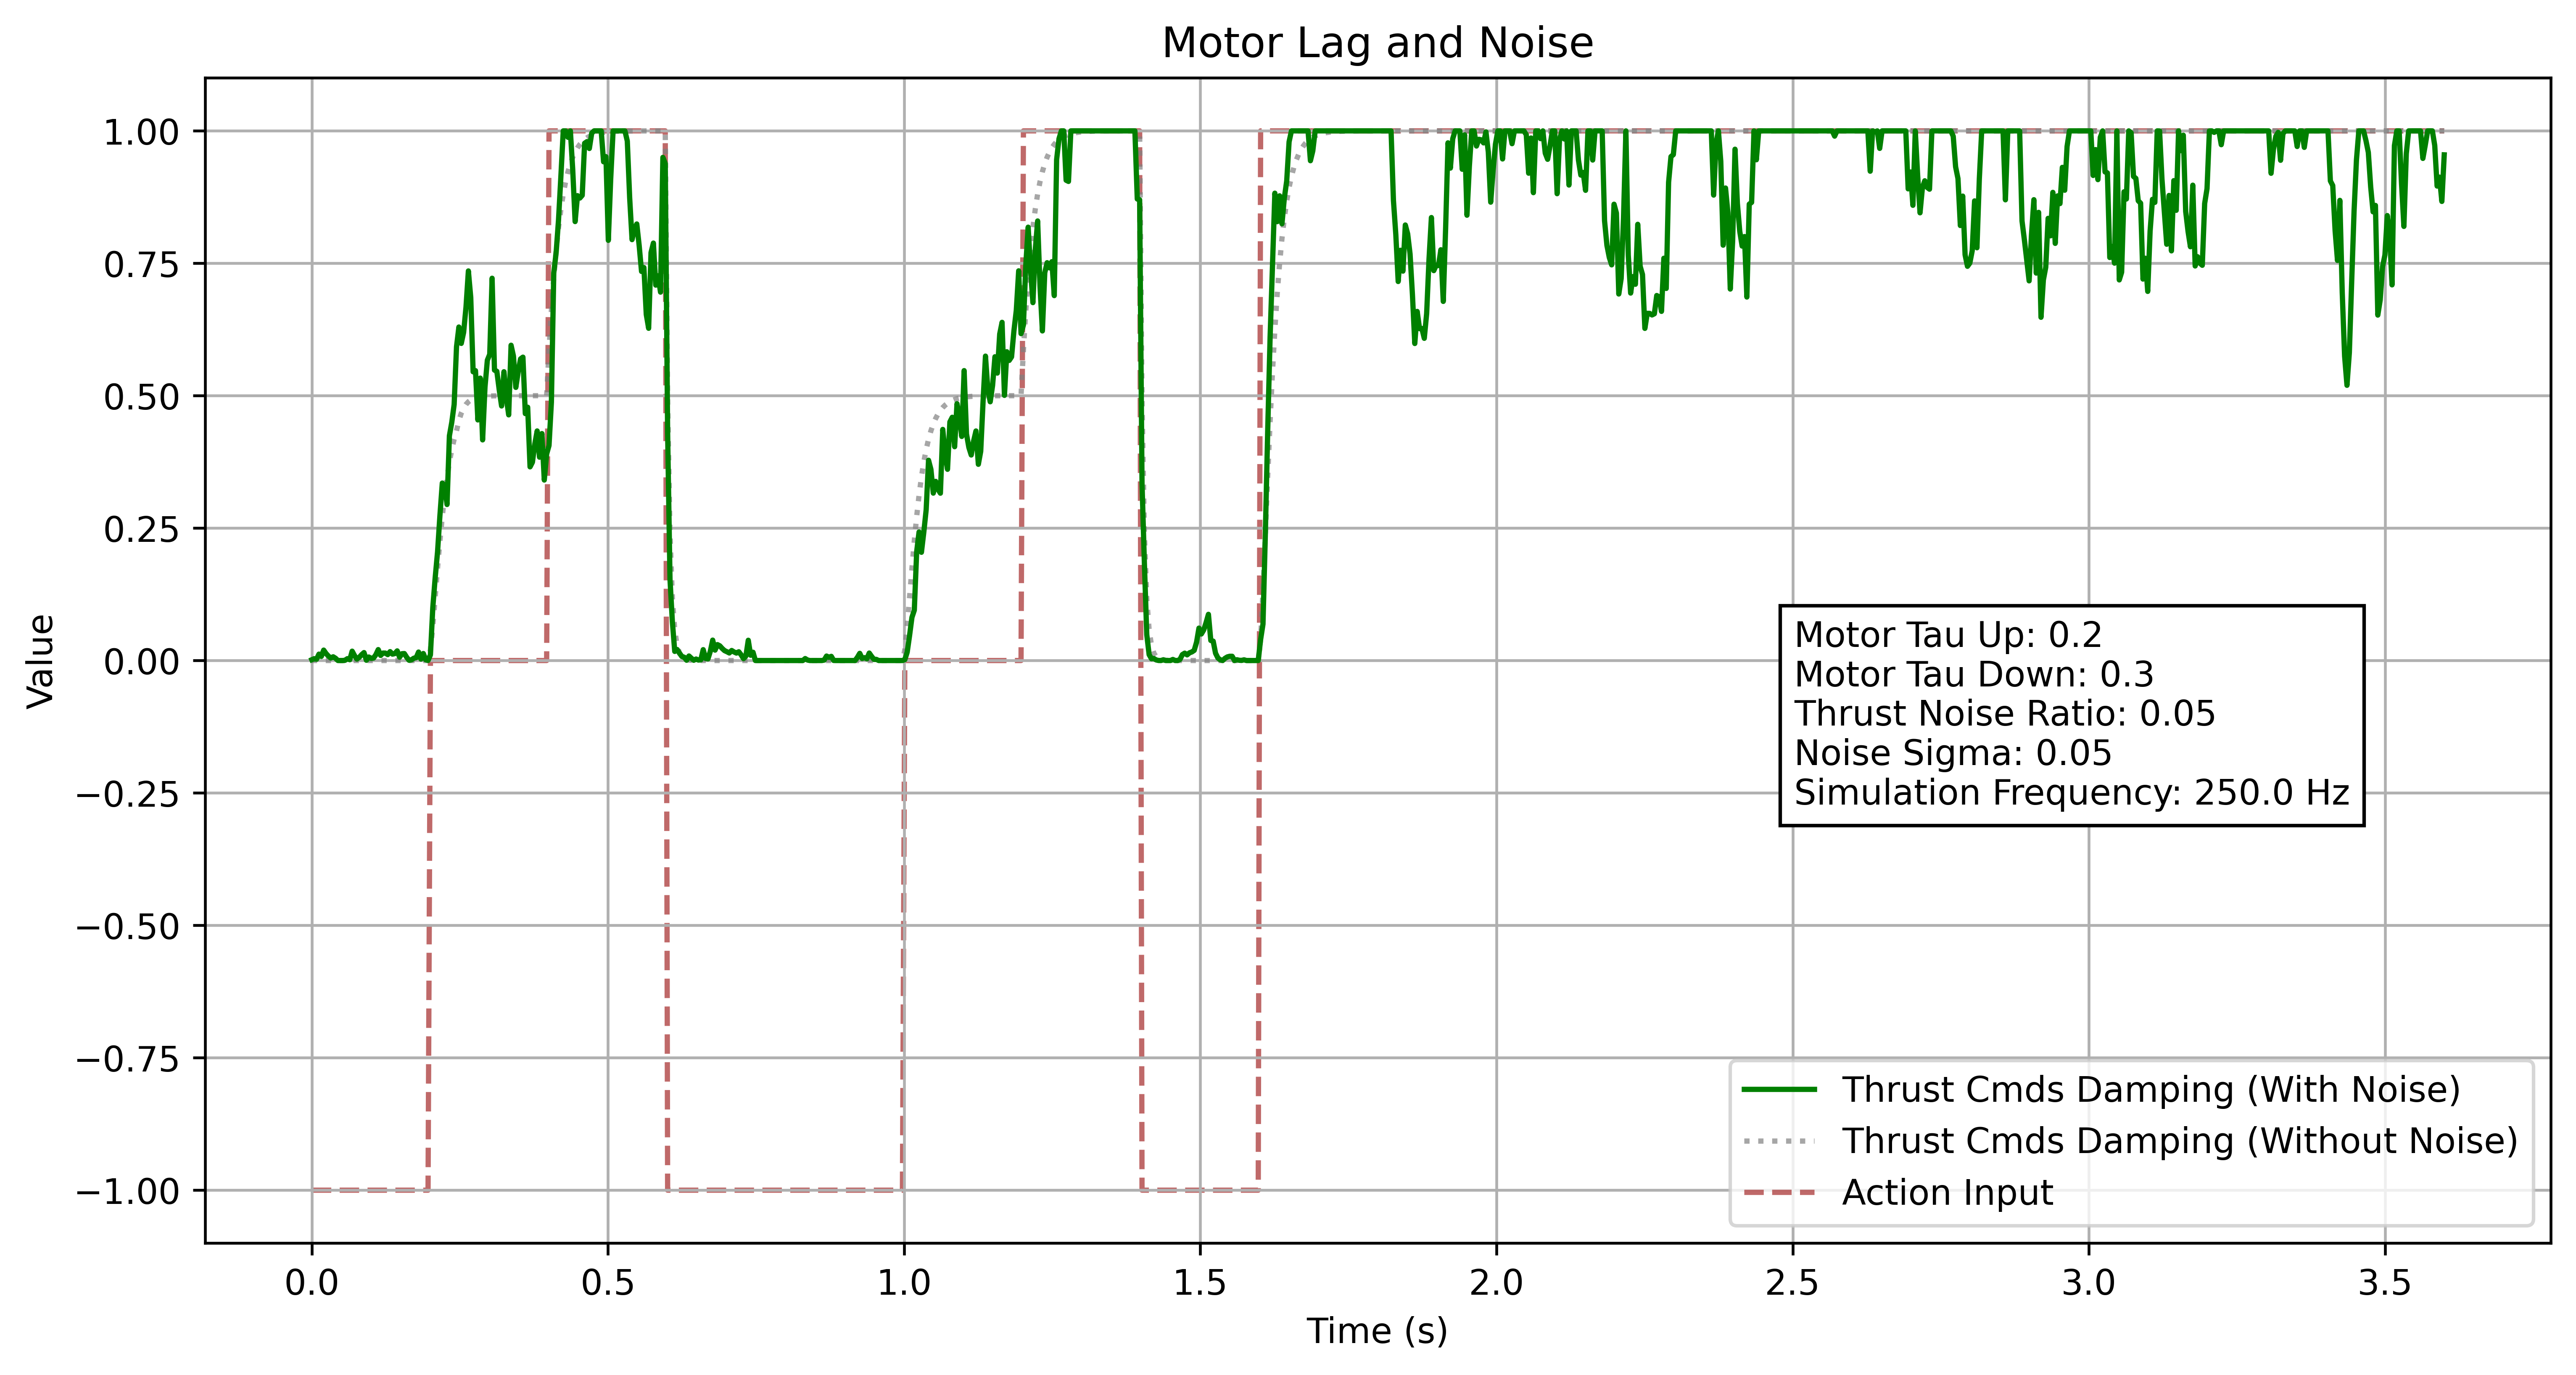

In [11]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

# Define the Ornstein-Uhlenbeck Noise class
class OUNoise:
    def __init__(self, size=4, mu=0.0, theta=0.15, sigma=0.2):
        self.size = size
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.state = np.ones(self.size) * self.mu

    def reset(self):
        self.state = np.ones(self.size) * self.mu

    def noise(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(len(x))
        self.state = x + dx
        return self.state


# Simulation parameters
dt = 1 / 250  # Time step for 250 Hz
motor_tau_up = 0.2
motor_tau_down = 1.0
thrust_noise_ratio = 0.05

# Generate action input
action = np.concatenate([
    np.tile(
        np.concatenate([
            np.full(50, -1.0),  # Stay at -1
            np.full(50, 0.0),   # Transition to 0
            np.full(50, 1.0),   # Transition to 1
            np.full(50, -1.0)   # Transition back to -1
        ]), 2  # Repeat twice
    ),
    np.full(int(2 / dt), 1.0)  # Stay at 1 for 2 seconds
])

# Extend the simulation time
steps = len(action)
simulation_time = steps * dt
time = np.linspace(0, simulation_time, steps)

# Initialize noise generator
ou_noise = OUNoise(size=1, sigma=thrust_noise_ratio)

# Reset arrays for storing results
thrust_cmds_damp_vals = []
thrust_cmds_damp_vals_no_noise = []

# Reset noise for the simulation
ou_noise.reset()

# Simulate system response
thrust_rot_damp = 0.0
thrust_cmds_damp = 0.0 

for i in range(steps):
    # Convert action from [-1,1] to [0,1]
    thrust_cmds = 0.5 * (action[i] + 1.0)
    thrust_cmds = np.clip(thrust_cmds, 0.0, 1.0)

    # Motor tau
    motor_tau = motor_tau_up if thrust_cmds >= thrust_cmds_damp else motor_tau_down
    motor_tau = np.clip(motor_tau, 0.0, 1.0)

    # Convert to sqrt scale
    thrust_rot = thrust_cmds ** 0.5
    thrust_rot_damp = motor_tau * (thrust_rot - thrust_rot_damp) + thrust_rot_damp

    # Add noise to thrust_rot_damp
    noise = ou_noise.noise()[0]
    thrust_rot_damp_with_noise = np.clip(thrust_rot_damp + noise, 0.0, 1.0)

    # Update damping responses
    thrust_cmds_damp = thrust_rot_damp_with_noise ** 2
    thrust_cmds_damp_no_noise = thrust_rot_damp ** 2

    # Store values for plotting
    thrust_cmds_damp_vals.append(thrust_cmds_damp)
    thrust_cmds_damp_vals_no_noise.append(thrust_cmds_damp_no_noise)

# Parameters text for the plot
parameters_text = (
    f"Motor Tau Up: {motor_tau_up}\n"
    f"Motor Tau Down: {motor_tau_down}\n"
    f"Thrust Noise Ratio: {thrust_noise_ratio}\n"
    f"Noise Sigma: {thrust_noise_ratio}\n"
    f"Simulation Frequency: {1/dt} Hz"
)

# Plot the results

plt.figure(figsize=(12, 6))
# Set high dpi
plt.rcParams["figure.dpi"] = 600

plt.plot(time, thrust_cmds_damp_vals, label="Thrust Cmds Damping (With Noise)", color="green", zorder=3)
plt.plot(
    time,
    thrust_cmds_damp_vals_no_noise,
    label="Thrust Cmds Damping (Without Noise)",
    linestyle=":",
    color="gray",
    alpha=0.7,
    zorder=2
)
plt.plot(
    time,
    action,
    label="Action Input",
    linestyle="--",
    color="brown",
    alpha=0.7,
    zorder=1
)
plt.xlabel("Time (s)")
plt.ylabel("Value")
plt.title("Motor Lag and Noise")
plt.legend(loc="lower right")

# Add parameters to the plot
plt.gcf().text(
    0.65, 0.4, parameters_text, fontsize=10, bbox=dict(facecolor="white", edgecolor="black", alpha=1.0)
)

plt.grid(True)
plt.show()
